#Foundations of Pattern Recognition and Machine Learning 2nd edition
Chapter 12 Figure 12.8<br>
Author: Ulisses Braga-Neto<br>
This code is distributed under the GNU LGPL license<br>

This python script demonstrates coding and training a physics-informed Gaussian process to find the velocity from scattered noisy data generated by the univariate advection of a tracer in a moving fluid, with a sinusoidal initial condition:
  \begin{aligned}
  q_t + vq_x = 0
  \end{aligned}
where $v$ is the constant velocity. The initial condition is  
\begin{equation}
  q(x,0) = \sin(x)
\end{equation}
This simple problem has as solution:
\begin{aligned}
     q(x,t) = \sin(x-vt)
  \end{aligned}
In other words, the initial sinusoisal profile is simply advected to the left with speed $v$. We assume $L = 16\pi$ and set the unknown velocity to $v = 5$.

In [ ]:
"""
Import libraries
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube as lhs

In [ ]:
"""
Problem definition and training data
"""

# parameters of the simulation
A =  1           # amplitude of sinusoisal
xl = 0           # left limit of interval
xr = 16*np.pi    # right limit of interval
ti = 0.0         # initial time
tf = 1.0         # final time
v = 10            # advection speed
eps = 0.2        # standard deviation of noise in the data
delta = 0.000001 # small value to add to the diagonal of K2

# training points (noisy data points)
Nx = 128 # uniformly spaced interior sensor locations
Nt = 8  # number of uniformly spaces snapshots
N = Nx*Nt
X = np.zeros([N,2])
X[:,0] = np.repeat(xl+(np.arange(Nx)+0.5)*(xr-xl)/Nx,Nt)
X[:,1] = np.tile(ti+(np.arange(Nt)+0.5)*(tf-ti)/Nt,Nx)

In [ ]:
"""
Marginal likelihood function
"""

def mrglik(lb,th,X,Y,Z):

    N = X.shape[0]
    Nres = Z.shape[0]

    # generate the K2 matrix
    K2 = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        for j in range(N):
            K2[i,j] = th[0]*th[0] * \
            np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
        K2[i,i] += lb[1]*lb[1]
        for j in range(Nres):
            K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+lb[0]*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            K2[N+i,j] = K2[j,N+i]
        for j in range(Nres):
            K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+lb[0]*lb[0]/th[1]/th[1] - \
            np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+lb[0]*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # generate the derivative of K2 wrt v
    dK2_dv = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        #for j in range(N):
        #    dK2_dlx[i,j] = 0
        for j in range(Nres):
            dK2_dv[i,N+j] = th[0]*th[0]*((X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            dK2_dv[N+i,j] = dK2_dv[j,N+i]
        for j in range(Nres):
            dK2_dv[N+i,N+j] = (2*th[0]*th[0]/th[1]/th[1])*(lb[0] - \
            ((Z[i,1]-Z[j,1])/th[2]/th[2]+lb[0]*(Z[i,0]-Z[j,0])/th[1]/th[1])*(Z[i,0]-Z[j,0])) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # generate the derivative of K2 wrt sig2
    dK2_ds2 = np.diag([2*lb[1]]*N+[0]*Nres)

    # compute alpha
    L,low = cho_factor(K2+delta*np.eye(N+Nres))
    alpha = cho_solve((L,low),Y)

    # compute K2^-1
    K2inv = cho_solve((L,low),np.eye(N+Nres))

    # compute alpha.alpha^T - K_2^-1
    aaK2 = alpha.dot(alpha.T) - K2inv

    # comput log-likelihood and its gradient
    ll = (0.5*Y.T.dot(alpha)+np.sum(np.log(np.diag(L)))+0.5*(N+Nres)*np.log(2*np.pi)).item()
    dll = np.zeros(2)
    dll[0] = -0.5*np.sum(aaK2[:]*dK2_dv[:])
    dll[1] = -0.5*np.sum(aaK2[:]*dK2_ds2[:])

    return (ll,dll)

def cb(intermediate_result):
    global it,r,lb_save,lik
    lb_save[r,:,it] = intermediate_result.x
    lik[r,it] = -intermediate_result.fun
    print('{0:4d}   {1:3.6f}   {2:3.6f}   {3:3.6f}' \
          .format(it,lb_save[r,0,it],lb_save[r,1,it],lik[r,it]))
    it += 1

In [ ]:
""""
PIGP training using direct implementation in numpy and scipy
"""

# Note: only the velocity and the noise std
# are estimated, while the kernel hyperparameters
# are kept fixed (see book text). No bounds are
# placed on the velocity and std estimates. The
# former can be positive or negative, while the
# latter enters only through the variance. The
# std estimate should be interpreted only by
# its magnitude (the sign can be diregarded).

# initialize GP parameters [sigma_k,lx,lt]
th = np.array([3.3078,2.6910,0.2377])

M = 10     # number of repetitions
Nres = 800 # training points (PDE residual points)
maxiter = 40
lik = np.zeros([M,maxiter])
lb_save = np.zeros([M,2,maxiter])

for r in range(M):

    # generate the training data responses
    Y = np.zeros([N+Nres,1])
    Y[0:N,0] = A*np.sin(X[0:N,0]-v*X[0:N,1]) + rd.normal(0,eps,N)
    #Y[N:-1,0] = 0

    # training points (PDE residual points)
    Z = lhs(2).random(Nres)
    Z[:,0] = xl+(xr-xl)*Z[:,0]
    Z[:,1] = ti+(tf-ti)*Z[:,1]

    rng = np.random.default_rng()
    lb = np.array([20*rng.random(),1.0]) # initial parameter guess
    print('\nrepetition: '+str(r))
    print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', 'v', 'sig', 'mrglik'))
    lb_save[r,:,0] = lb
    lik[r,0] = -mrglik(lb,th,X,Y,Z)[0]
    print('{0:4d}   {1:3.6f}   {2:3.6f}   {3:3.6f}' \
          .format(0,lb_save[r,0,0],lb_save[r,1,0],lik[r,0]))
    it = 1
    opt=minimize(mrglik,lb,args=(th,X,Y,Z),method='L-BFGS-B',jac=True,
                 options={"maxiter":maxiter},callback=cb)
    lb_save[r,0,it:] = opt.x[0]
    lb_save[r,1,it:] = opt.x[1]
    lik[r,it:] = -opt.fun
    print("Final trained values:")
    print("v      = {:.6f}".format(lb_save[r,0,it]))
    print("sig    = {:.6f}".format(lb_save[r,1,it]))
    print("mrglik = {:.6f}".format(lik[r,it]))


repetition: 0
Iter   v           sig         mrglik   
   0   19.262508   1.000000   629.711306
   1   19.249106   0.667288   701.503939
   2   19.245950   0.798385   703.470125
   3   19.242080   0.746385   710.379485
   4   19.233739   0.727653   710.900666
   5   19.205672   0.737092   711.432165
   6   19.105636   0.747303   713.013534
   7   18.405597   0.786485   722.312023
   8   16.507269   0.852932   745.040138
   9   8.727394   1.064330   914.046126
  10   10.079838   0.981716   937.999052
  11   10.885085   0.335313   1471.152341
  12   10.856786   0.258042   1503.848489
  13   10.522113   0.202146   1658.896241
  14   10.186377   0.180344   1785.071321
  15   9.860396   0.224280   1851.439645
  16   9.834047   0.213049   1853.873977
  17   9.864918   0.211740   1854.457832
  18   9.872071   0.211148   1854.480141
  19   9.871894   0.211224   1854.480245
  20   9.871892   0.211223   1854.480249
Final trained values:
v      = 9.871892
sig    = 0.211223
mrglik = 1854.480249



velocity estimate = 8.9141 +/- 2.7280
velocity relative error = 1.09e-01 +/- 2.73e-01
noise standard deviation estimate = 0.2596 +/- 0.1557
noise standard deviation relative error = 2.98e-01 +/- 1.36e+01


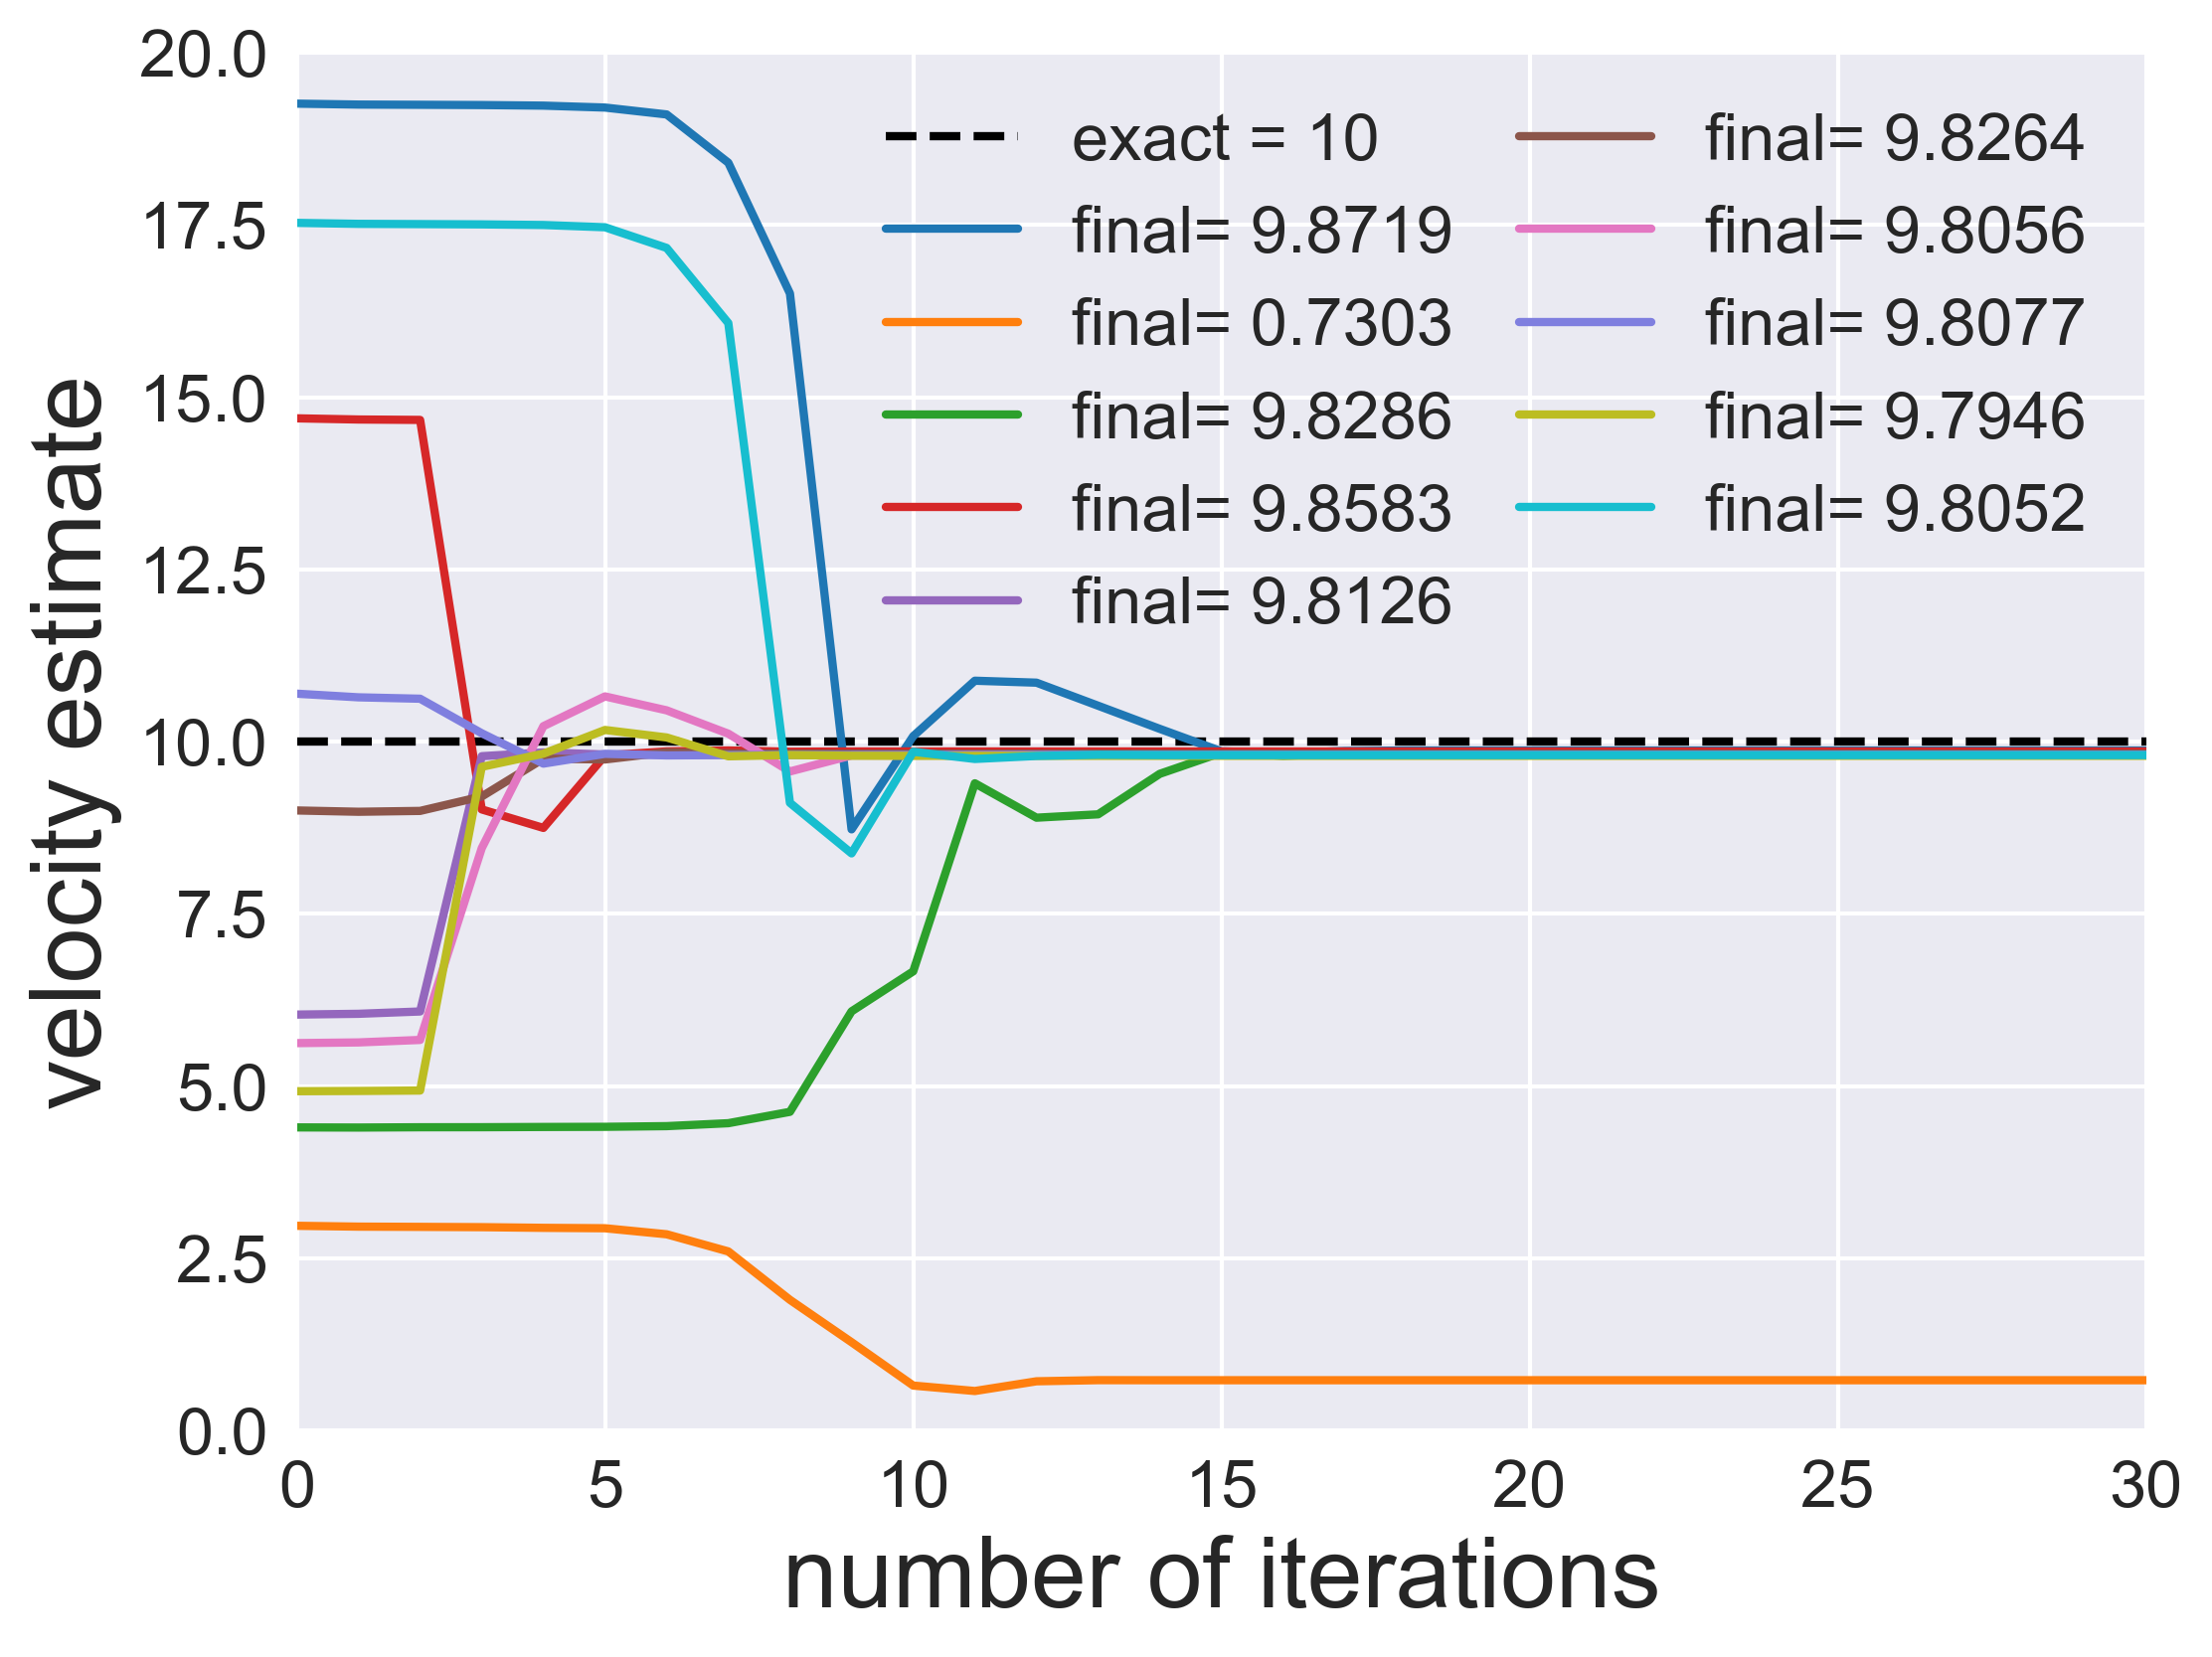

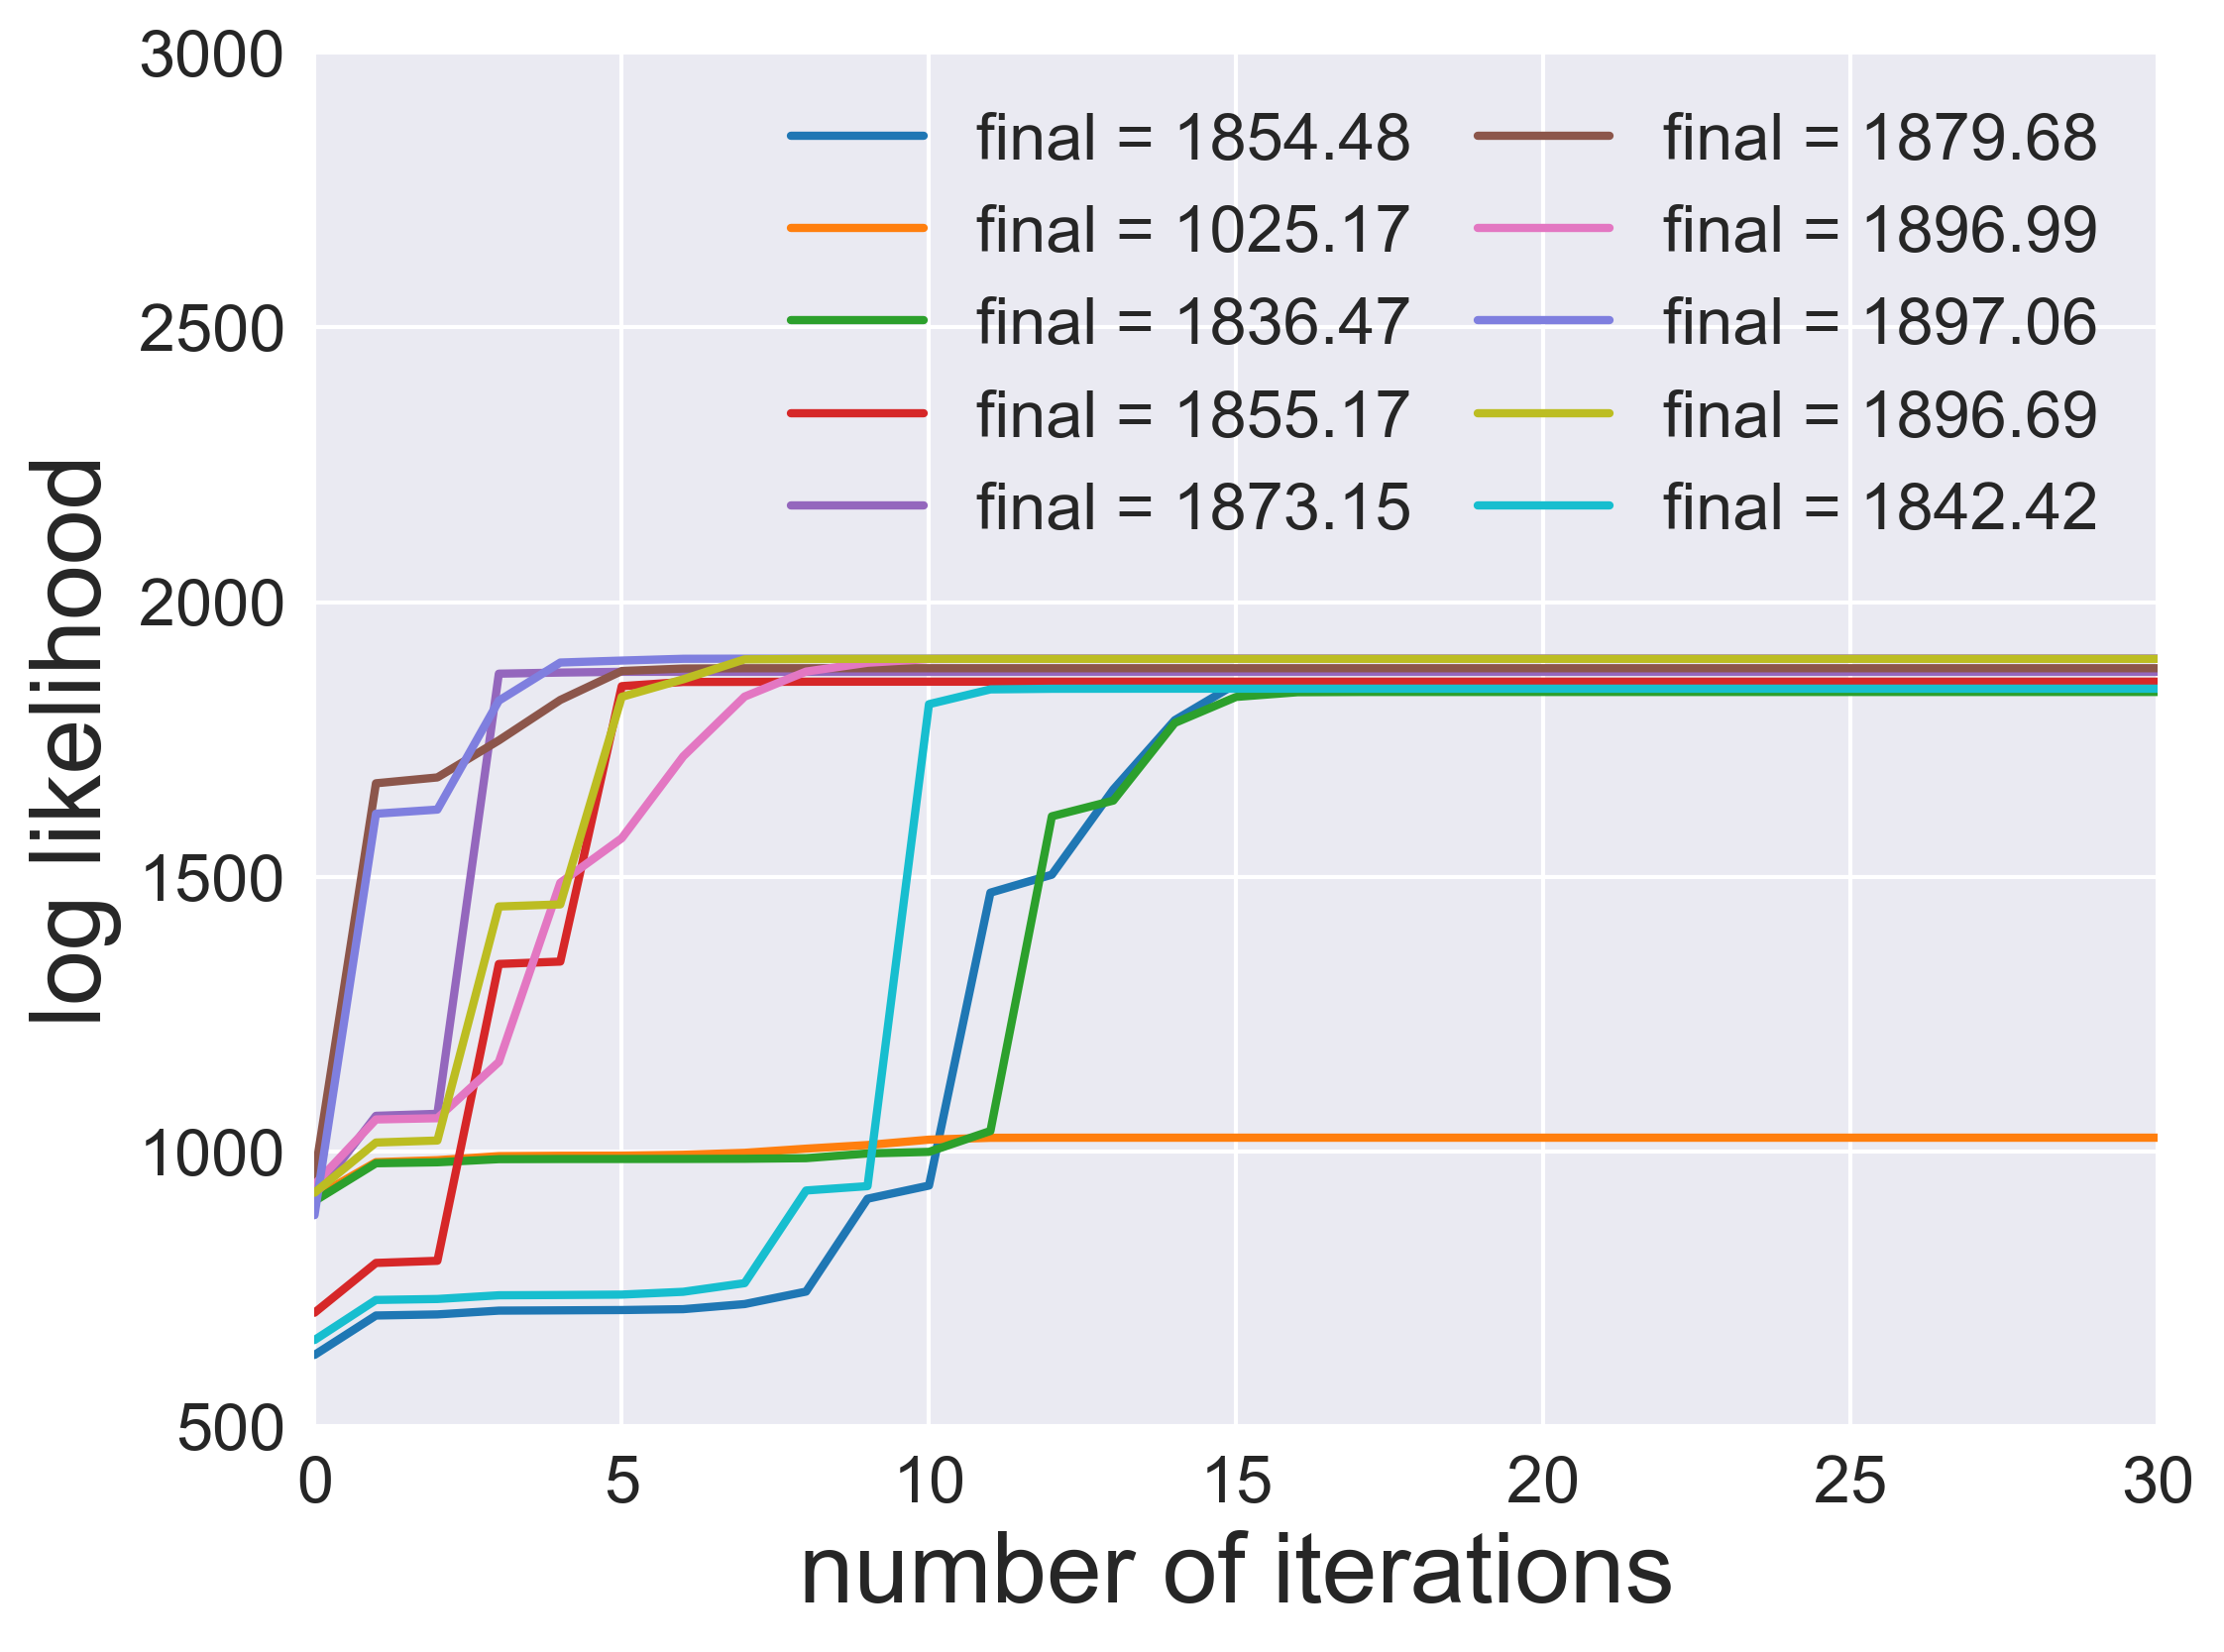

In [ ]:
"""
Display results
"""

#Display results

print('velocity estimate = {:.4f} +/- {:.4f}'.format(np.mean(lb_save[:,0,-1]),np.std(lb_save[:,0,-1])))
print('velocity relative error = {:.2e} +/- {:.2e}'.format(np.mean(np.abs(lb_save[:,0,-1]-v)/v),np.std(np.abs(lb_save[:,0,-1]-v)/v)))
print('noise standard deviation estimate = {:.4f} +/- {:.4f}'.format(np.mean(np.abs(lb_save[:,1,-1])),np.std(np.abs(lb_save[:,1,-1]))))
print('noise standard deviation relative error = {:.2e} +/- {:.2e}'.format(np.mean(np.abs(np.abs(lb_save[:,1,-1])-eps)/eps),np.std(np.abs(np.abs(lb_save[:,0,-1])-eps)/eps)))

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7fdf','#bcbd22','#17becf']

# plot the evolution of vhat
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=300)
plt.xlabel('number of iterations',size=24)
plt.ylabel('velocity estimate',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(v,0,maxiter,colors='black',linestyles='dashed',lw=2,label='exact = {:.0f}'.format(v))
for r in range(M):
    plt.plot(np.arange(maxiter),lb_save[r,0,],color=colors[r % 10],lw=2,label='final= {:.4f}'.format(lb_save[r,0,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1)
plt.xlim(0,30)
plt.ylim(0,20)
plt.show()

# plot the evolution of the likelihood
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=300)
plt.xlabel('number of iterations',size=24)
plt.ylabel('log likelihood',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
xsp = np.linspace(0,maxiter-1,300)
for r in range(M):
    plt.plot(np.arange(maxiter),lik[r,],color=colors[r % 10],lw=2,label='final = {:.2f}'.format(lik[r,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1)
plt.xlim(0,30)
plt.ylim(500,3000)
plt.show()